# Simulation Algorithm:
<ol>
    <li>Assuming that missile position is $(x_m, z_m, y_m) = (0, 0, 0)$, and given $D_0$, $\varepsilon_0$, $\sigma_0$, target velocity $V_T$ and missile velocity $V_M$. Then, the initial target position can be determined using the following equations:
       $$
        x_t = D_0\; cos(\varepsilon_0)\; cos(\sigma_0)\\
        z_t = D_0\; cos(\varepsilon_0)\; sin(\sigma_0)\\
        y_t = D_0\; sin(\varepsilon_0)\\
       $$
        
   </li>
   <li>Instantiate two objects from the vehicle class. One represents the target vehicle and the second represents the missile.</li>
    <li>Based on the given $\delta t$ and the $t_f$, the simulation vectors are initialized with the needed size.</li>
<li>Loop over the given time period, and for every time step:
<ul>
    <li>Solve the relative velocity ordinary differential equations to get its three components in the spherical coordinates.
            $$
            \dot D = V_T\; cos(\sigma-\varphi_T)\; cos(\varepsilon-\theta_T)\; - \;V_M\; cos(\sigma-\varphi_M)\; cos(\varepsilon-\theta_M)$$
           $$D\; \dot \varepsilon = \;V_M\; cos(\sigma-\varphi_M)\; sin(\varepsilon-\theta_M)\;-\;V_T\; cos(\sigma-\varphi_T)\; sin(\varepsilon-\theta_T)$$
           $$D\; cos(\varepsilon)\; \dot \sigma = \;V_M\; sin(\sigma-\varphi_M)\; cos(\theta_M)\;-\;V_T\; sin(\sigma-\varphi_T)\; cos(\theta_T)\\
            $$
    </li>
<li>Those ordinary differential equations are solved using "Solver" function, which have two options to solve those ODEs either using Euler or Runge Kutta.</li>
<li>After solving the ODEs, the new values for $D$, $\varepsilon$ and $\sigma$ are estimated.</li>
<li>Then the missile velocity vector angles are updated using the Ideal Bond equations as follows:
<ol> 
<li>For Pure Pursuit: $\theta_M = \varepsilon$ and $\varphi_M = \sigma$.</li>
<li>For Deviated Pursuit: $\theta_M=\varepsilon-\varepsilon_P$ and $\varphi_M=\sigma-\sigma_P$.</li>
<li>For Porportional Navigation: $\dot \theta_M=k_1 \dot\varepsilon$ and $\dot \varphi_M=k_2\dot \sigma$.</li>
</ol>
</li>
    
<li>After solving the Ideal Bond equations, the new position of the missile can be estimated as follows:
$$V_M = constant\\$$
$$r = V_M\; \delta t\\$$
$$\theta_M = \theta_M + \delta \theta_M\\$$
$$\varphi_M = \varphi_M + \delta \varphi_M\\$$
$$x_M = x_M + r\; cos(\theta_M)\; cos(\varphi_M)\\$$
$$z_M = z_M + r \;cos(\theta_M) \;sin(\varphi_M)\\$$
$$y_M = y_M + r \;sin(\theta_M)\\$$
</li>
</ul>         
</li>
<li>When the loop finishes there will be two vectores that describe the full trajectory of both the target and missile.</li>
</ol>

# Vehicle Class Initialization

In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy import sin 
from numpy import cos
from math import acos
from math import atan
from math import radians
from math import sqrt

class Vehicle:
    def __init__(self, v = 500, x = 0, z = 0, y = 0, theta = 0, phi = 0):
        self.position = []
        self.v = v
        self.theta = theta
        self.phi = phi
        self.x = x
        self.z = z
        self.y = y
        self.r = sqrt(self.x**2 + self.z**2 + self.y**2)
        self.dx = self.dz = self.dy = 0
        self.position.append([self.x, self.z, self.y])
    
    def update(self, dv, dtheta, dphi, dt):
        self.v += dv
        self.r = self.v * dt
        self.theta += dtheta
        self.phi += dphi
        self.dx = self.r * cos(self.theta) * cos(self.phi)
        self.dz = self.r * cos(self.theta) * sin(self.phi)
        self.dy = self.r * sin(self.theta)
        self.x += self.dx #if abs(self.dx) > (0.0001 * dt) else 0
        self.z += self.dz #if abs(self.dz) > (0.0001 * dt) else 0
        self.y += self.dy #if abs(self.dy) > (0.0001 * dt) else 0
        self.position.append([self.x, self.z, self.y])

# Simulation Class Initialization

In [2]:
class Simulation:
    def __init__(self, D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m):
        self.D0 = D0
        self.epsilon0 = epsilon0
        self.sigma0 = sigma0
        self.VT = VT
        self.VM = VM
        self.dt = dt
        self.tf = tf
        self.theta_t = theta_t
        self.phi_t = phi_t
        self.theta_m = theta_m
        self.phi_m = phi_m
    
    def simulation(self, G = 2, S = 1, manuver_target = True, plot = False):
        def vectorInit():
            def epsilon0_sigma0():
                AB = np.array(target.position) - np.array(missile.position)
                AB = AB[0]
                BC = np.array(target.position) - np.array(missile.position)
                BC[0][2] = 0
                BC = BC[0]
                CD = np.array(target.position) - np.array(missile.position)
                CD[0][1] = CD[0][2] = 0
                CD = CD[0]
                AB_mg = np.linalg.norm(AB)
                BC_mg = np.linalg.norm(BC)
                CD_mg = np.linalg.norm(CD)
                ABdotBC = np.dot(AB,BC)
                BCdotCD = np.dot(BC,CD)
                epsilon0 = acos(ABdotBC / (AB_mg * BC_mg))
                sigma0 = acos(BCdotCD / (CD_mg * BC_mg))
                return epsilon0, sigma0
            time = np.arange(0, self.tf, self.dt)
            D       = [None] * len(time)
            epsilon = [None] * len(time)
            thetam = [None] * len(time)
            Jn_theta = [None] * len(time)
            Jn_phi = [None] * len(time)
            thetam[0] = 0
            sigma   = [None] * len(time)
            D[0] = target.r - missile.r
            epsilon[0], sigma[0] = epsilon0_sigma0()
            Jn_theta[0] = 0
            Jn_phi[0] = 0
            return D, epsilon, sigma, thetam, time, Jn_theta, Jn_phi
        
        def targetMove(manuver_target = True):
            if manuver_target == True:
                maxdef = 8 * self.dt
                dtheta_t = radians(random.uniform(-maxdef, maxdef))
                dphi_t = radians(random.uniform(-maxdef, maxdef))
                target.update(0, dtheta_t, dphi_t, self.dt)
            else:
                dtheta_t = 0
                dphi_t = 0
                target.update(0, dtheta_t, dphi_t, self.dt)
                
        def Solver():
            def RungeKutta(f, y0):
                k1 = f(t0, y0)
                k2 = f(t0 + 0.5 * self.dt, y0 + 0.5 * k1)
                k3 = f(t0 + 0.5 * self.dt, y0 + 0.5 * k2)
                k4 = f(t0 + self.dt, y0 + k3)
                y = (k1 + k2 + k2 + k3 + k3 + k4) / 6
                return y
            
            def Euler(f, y0):
                return f(t0, y0)
            
            def D_dotf(t, D):
                delta_D = target.v * cos(sigma0-target.phi) * cos(epsilon0-target.theta) - missile.v * cos(sigma0-missile.phi) * cos(epsilon0-missile.theta)
                return delta_D
            
            def epsilon_dotf(t, epsilon_0):
                delta_epsilon = (missile.v * cos(sigma0-missile.phi) * sin(epsilon_0-missile.theta) - target.v * cos(sigma0-target.phi) * sin(epsilon_0-target.theta))/D0
                return delta_epsilon
            
            def sigma_dotf(t, sigma_0):
                delta_sigma = (missile.v * sin(sigma_0-missile.phi) * cos(missile.theta) - target.v * sin(sigma_0-target.phi) * cos(target.theta))/(D0*cos(epsilon0))
                return delta_sigma
            
            if solver == "Euler":
                D_d = Euler(D_dotf, D0)
                epsilon_d = Euler(epsilon_dotf, epsilon0)
                sigma_d = Euler(sigma_dotf, sigma0)
            elif solver == "Runge Kutta":
                D_d = RungeKutta(D_dotf, D0)
                epsilon_d = RungeKutta(epsilon_dotf, epsilon0)
                sigma_d = RungeKutta(sigma_dotf, sigma0)
            return D_d, epsilon_d, sigma_d
        
        def updateObservation():
            epsilon[i] = epsilon[i-1] + epsilon_d * self.dt
            sigma[i] = sigma[i-1] + sigma_d * self.dt
            D[i] = D[i-1] + D_d * self.dt
            
        def IdealBond():
            thetaM_old = missile.theta
            phiM_old = missile.phi
            # Missile gives new commands
            if Guidance_Law == "Pure Pursuit":
                thetaM_new = epsilon[i]
                phiM_new = sigma[i]
            elif Guidance_Law == "Deviated Pursuit":
                epsilon_p = 5
                sigma_p = 5
                epsilon_p = radians(epsilon_p)
                sigma_p = radians(sigma_p)
                thetaM_new = epsilon[i] - epsilon_p
                phiM_new = sigma[i] - sigma_p
            elif Guidance_Law == "Porportional Navigation":
                k1 = 5
                k2 = 5
                thetaM_new = thetaM_old + k1 * epsilon_d * self.dt
                phiM_new = phiM_old + k2 * sigma_d * self.dt
            dtheta_m = thetaM_new - thetaM_old
            dphi_m = phiM_new - phiM_old
            return dtheta_m, dphi_m
        
        def PlotTrajectories(target_position, missile_position, view = "3D", title = "Figure"):
            xt, zt, yt = zip(*target_position)
            xm, zm, ym = zip(*missile_position)
            if view == "3D":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                ax = Axes3D(fig)
                #ax.set_xlim3d(-5000, 80000)
                #ax.set_ylim3d(-5000, 80000)
                #ax.set_zlim3d(-5000, 80000)
                ax.set_xlabel('X axis', fontsize=16)
                ax.set_zlabel('Y axis', fontsize=16)
                ax.set_ylabel('Z axis', fontsize=16)

                ax.plot(xt, zt, yt, label='Target Trajectory')
                ax.plot(xm, zm, ym, label='Missile Trajectory')
                ax.scatter(xt[-1], zt[-1], yt[-1], c='r', marker='x')   # End point
                ax.scatter(xt[0], zt[0], yt[0], c='k', marker='*')   # Start point
                ax.scatter(xm[-1], zm[-1], ym[-1], c='r', marker='o')   # End point
                ax.scatter(xm[0], zm[0], ym[0], c='g', marker='s')   # Start point
                ax.legend()
                plt.grid()
                plt.show()
            elif view == "XY" or view == "YX":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                plt.xlabel('X axis', fontsize=16)
                plt.ylabel('Y axis', fontsize=16)
                plt.plot(xt, yt, label='Target Trajectory')
                plt.plot(xm, ym, label='Missile Trajectory')
                plt.scatter(xt[-1], yt[-1], c='r', marker='x')   # End point
                plt.scatter(xt[0], yt[0], c='k', marker='*')   # Start point
                plt.scatter(xm[-1], ym[-1], c='r', marker='o')   # End point
                plt.scatter(xm[0], ym[0], c='g', marker='s')   # Start point
                plt.legend()
                plt.grid()
                plt.show()
            elif view == "ZY" or view == "YZ":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                plt.xlabel('Z axis', fontsize=16)
                plt.ylabel('Y axis', fontsize=16)
                plt.plot(zt, yt, label='Target Trajectory')
                plt.plot(zm, ym, label='Missile Trajectory')
                plt.scatter(zt[-1], yt[-1], c='r', marker='x')   # End point
                plt.scatter(zt[0], yt[0], c='k', marker='*')   # Start point
                plt.scatter(zm[-1], ym[-1], c='r', marker='o')   # End point
                plt.scatter(zm[0], ym[0], c='g', marker='s')   # Start point
                plt.legend()
                plt.grid()
                plt.show()
            elif view == "XZ" or view == "ZX":
                fig = plt.figure(figsize=(8, 8))
                fig.suptitle(title, fontsize=20)
                plt.xlabel('X axis', fontsize=16)
                plt.ylabel('Z axis', fontsize=16)
                plt.plot(zt, xt, label='Target Trajectory')
                plt.plot(zm, xm, label='Missile Trajectory')
                plt.scatter(zt[-1], xt[-1], c='r', marker='x')   # End point
                plt.scatter(zt[0], xt[0], c='k', marker='*')   # Start point
                plt.scatter(zm[-1], xm[-1], c='r', marker='o')   # End point
                plt.scatter(zm[0], xm[0], c='g', marker='s')   # Start point
                plt.legend()
                plt.grid()
                plt.show()
            
        xt = self.D0 * cos(radians(self.epsilon0))*cos(radians(self.sigma0))
        zt = self.D0 * cos(radians(self.epsilon0))*sin(radians(self.sigma0))
        yt = self.D0 * sin(radians(self.epsilon0))
        target = Vehicle(v = self.VT, x = xt, z = zt, y = yt, theta = radians(self.theta_t), phi = radians(self.phi_t))
        missile = Vehicle(v = self.VM, x = 0, z = 0, y = 0, theta = radians(self.theta_m), phi = radians(self.phi_m))       
        Guidance_Laws = ["Pure Pursuit", "Deviated Pursuit", "Porportional Navigation"]
        Guidance_Law = Guidance_Laws[G]       
        Solvers = ["Euler", "Runge Kutta"]
        solver = Solvers[S]
        D, epsilon, sigma, thetam, time, Jn_theta, Jn_phi = vectorInit()
        missile.theta = epsilon[0]
        missflag = 0
        
        timeHit = None
        
        for i in range(1, len(time)):
            t0 = time[i-1]
            t1 = time[i]
            D0 = D[i-1]
            epsilon0 = epsilon[i-1]
            sigma0 = sigma[i-1] 
            targetMove(manuver_target)
            D_d, epsilon_d, sigma_d = Solver()
            updateObservation()
            
            missDistance = 20
            if Guidance_Law == "Porportional Navigation":
                missDistance *= 0.5
            if abs(D[i]) < missDistance:
                timeHit = time[i]
                print("Missile hit the target using ", Guidance_Law," after ", timeHit," seconds")
                break
            elif D[i] > D[i-1]:
                missflag = missflag + 1
                if missflag == 2:
                    print("Missile missed the target")
                    break
                else:
                    missflag = 0
            
            dtheta_m, dphi_m = IdealBond()
            missile.update(0, dtheta_m, dphi_m, self.dt)
            thetam[i] = missile.theta
            Jn_theta[i] = missile.v * dtheta_m
            Jn_phi[i] = missile.v * dphi_m * cos(thetam[i])
            
        if plot == True:
            PlotTrajectories(target.position, missile.position, "3D", "3D Trajectory")
        return target.position, missile.position, timeHit, Jn_theta, Jn_phi

# Case Study Conditions

Missile hit the target using  Pure Pursuit  after  74.88  seconds


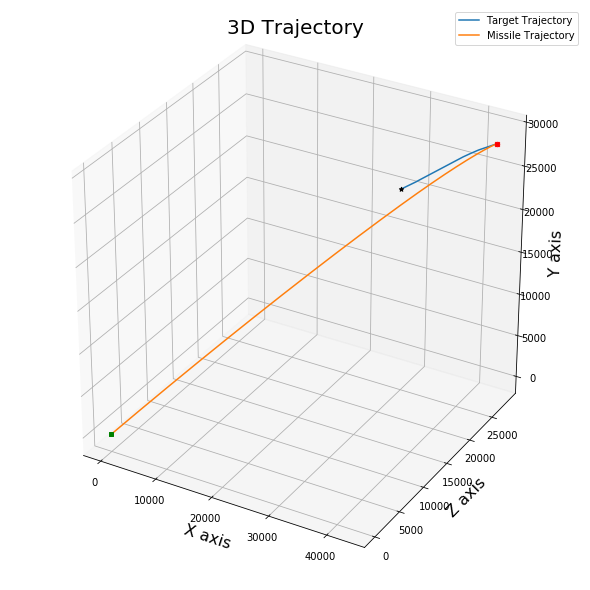

In [3]:
D0 = 50000
epsilon0 = 35
sigma0 = 20
VT = 200
VM = 800
dt = 0.01
tf = 1000
theta_t = 0
phi_t = 70
theta_m = 0
phi_m = 0
S = 1
manuver_target = True
G = 0
caseGeneral = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target, missile, t, Jtheta, Jphi = caseGeneral.simulation(G, S, manuver_target, plot = True)

Missile hit the target using  Deviated Pursuit  after  76.16  seconds


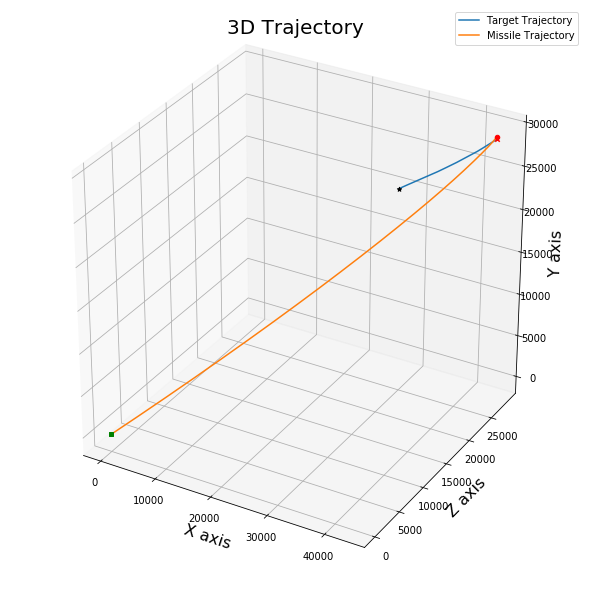

In [4]:
G = 1
caseGeneral = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target, missile, t, Jtheta, Jphi = caseGeneral.simulation(G, S, manuver_target, plot = True)

Missile hit the target using  Porportional Navigation  after  75.03  seconds


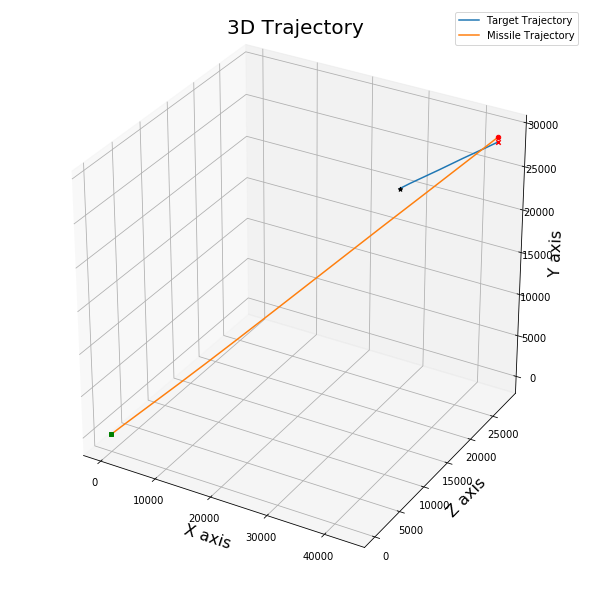

In [5]:
G = 2
caseGeneral = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target, missile, t, Jtheta, Jphi = caseGeneral.simulation(G, S, manuver_target, plot = True)

# Compare Guidance Laws

In [6]:
def PlotComparisons(target_position, missile_position0, missile_position1, missile_position2, view = "3D", title = "Figure"):
    xt, zt, yt = zip(*target_position)
    xm0, zm0, ym0 = zip(*missile_position0)
    xm1, zm1, ym1 = zip(*missile_position1)
    xm2, zm2, ym2 = zip(*missile_position2)

    if view == "3D":
        fig = plt.figure(figsize=(8, 8))
        fig.suptitle(title, fontsize=20)
        ax = Axes3D(fig)
        #ax.set_xlim3d(-5000, 80000)
        #ax.set_ylim3d(-5000, 80000)
        #ax.set_zlim3d(-5000, 80000)
        ax.set_xlabel('X axis', fontsize=16)
        ax.set_zlabel('Y axis', fontsize=16)
        ax.set_ylabel('Z axis', fontsize=16)

        ax.plot(xt, zt, yt, label='Target Trajectory')
        ax.plot(xm0, zm0, ym0, label='Pure Pursuit')
        ax.plot(xm1, zm1, ym1, label='Deviated Pursuit')
        ax.plot(xm2, zm2, ym2, label='Porportional Navigation')
        
        ax.scatter(xt[-1], zt[-1], yt[-1], c='r', marker='x')   # End point
        ax.scatter(xt[0], zt[0], yt[0], c='k', marker='*')   # Start point
        
        ax.scatter(xm0[-1], zm0[-1], ym0[-1], c='r', marker='o')   # End point
        ax.scatter(xm0[0], zm0[0], ym0[0], c='g', marker='s')   # Start point
        ax.scatter(xm1[-1], zm1[-1], ym1[-1], c='r', marker='o')   # End point
        ax.scatter(xm1[0], zm1[0], ym1[0], c='g', marker='s')   # Start point
        ax.scatter(xm2[-1], zm2[-1], ym2[-1], c='r', marker='o')   # End point
        ax.scatter(xm2[0], zm2[0], ym2[0], c='g', marker='s')   # Start point
        ax.legend()
        plt.grid()
        plt.show()
    elif view == "XY" or view == "YX":
        fig = plt.figure(figsize=(8, 8))
        fig.suptitle(title, fontsize=20)
        plt.xlabel('X axis', fontsize=16)
        plt.ylabel('Y axis', fontsize=16)
        
        plt.plot(xt, yt, label='Target Trajectory')
        plt.plot(xm0, ym0, label='Pure Pursuit')
        plt.plot(xm1, ym1, label='Deviated Pursuit')
        plt.plot(xm2, ym2, label='Porportional Navigation')
        
        plt.scatter(xt[-1], yt[-1], c='r', marker='x')   # End point
        plt.scatter(xt[0], yt[0], c='k', marker='*')   # Start point
        
        plt.scatter(xm0[-1], ym0[-1], c='r', marker='o')   # End point
        plt.scatter(xm0[0], ym0[0], c='g', marker='s')   # Start point
        plt.scatter(xm1[-1], ym1[-1], c='r', marker='o')   # End point
        plt.scatter(xm1[0], ym1[0], c='g', marker='s')   # Start point
        plt.scatter(xm2[-1], ym2[-1], c='r', marker='o')   # End point
        plt.scatter(xm2[0], ym2[0], c='g', marker='s')   # Start point
        plt.legend()
        plt.grid()
        plt.show()
    elif view == "ZY" or view == "YZ":
        fig = plt.figure(figsize=(8, 8))
        fig.suptitle(title, fontsize=20)
        plt.xlabel('Z axis', fontsize=16)
        plt.ylabel('Y axis', fontsize=16)
        plt.plot(zt, yt, label='Target Trajectory')
        plt.plot(zm0, ym0, label='Pure Pursuit')
        plt.plot(zm1, ym1, label='Deviated Pursuit')
        plt.plot(zm2, ym2, label='Porportional Navigation')
        
        plt.scatter(zt[-1], yt[-1], c='r', marker='x')   # End point
        plt.scatter(zt[0], yt[0], c='k', marker='*')   # Start point
        
        plt.scatter(zm0[-1], ym0[-1], c='r', marker='o')   # End point
        plt.scatter(zm0[0], ym0[0], c='g', marker='s')   # Start point
        plt.scatter(zm1[-1], ym1[-1], c='r', marker='o')   # End point
        plt.scatter(zm1[0], ym1[0], c='g', marker='s')   # Start point
        plt.scatter(zm2[-1], ym2[-1], c='r', marker='o')   # End point
        plt.scatter(zm2[0], ym2[0], c='g', marker='s')   # Start point
        plt.legend()
        plt.grid()
        plt.show()
    elif view == "XZ" or view == "ZX":
        fig = plt.figure(figsize=(8, 8))
        fig.suptitle(title, fontsize=20)
        plt.xlabel('X axis', fontsize=16)
        plt.ylabel('Z axis', fontsize=16)
        plt.plot(xt, zt, label='Target Trajectory')
        plt.plot(xm0, zm0, label='Pure Pursuit')
        plt.plot(xm1, zm1, label='Deviated Pursuit')
        plt.plot(xm2, zm2, label='Porportional Navigation')
        
        plt.scatter(xt[-1], zt[-1], c='r', marker='x')   # End point
        plt.scatter(xt[0], zt[0], c='k', marker='*')   # Start point
        
        plt.scatter(xm0[-1], zm0[-1], c='r', marker='o')   # End point
        plt.scatter(xm0[0], zm0[0], c='g', marker='s')   # Start point
        plt.scatter(xm1[-1], zm1[-1], c='r', marker='o')   # End point
        plt.scatter(xm1[0], zm1[0], c='g', marker='s')   # Start point
        plt.scatter(xm2[-1], zm2[-1], c='r', marker='o')   # End point
        plt.scatter(xm2[0], zm2[0], c='g', marker='s')   # Start point
        plt.legend()
        plt.grid()
        plt.show()

# Case 1: Incoming Non-Manuvering Target

In [7]:
theta_t = 180
case1 = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target0, missile0, t0, Jtheta0, Jphi0 = case1.simulation(G = 0, S = 1, manuver_target = False, plot = False)
target1, missile1, t1, Jtheta1, Jphi1 = case1.simulation(G = 1, S = 1, manuver_target = False, plot = False)
target2, missile2, t2, Jtheta2, Jphi2 = case1.simulation(G = 2, S = 1, manuver_target = False, plot = False)

Missile hit the target using  Pure Pursuit  after  58.03  seconds
Missile hit the target using  Deviated Pursuit  after  57.96  seconds
Missile hit the target using  Porportional Navigation  after  57.24  seconds


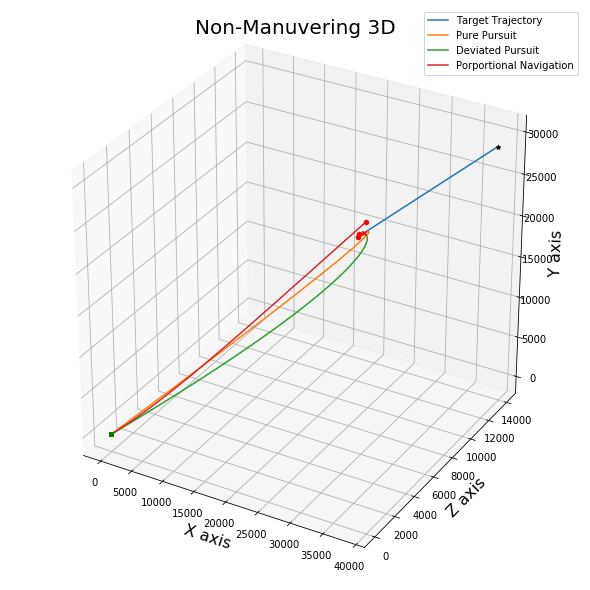

In [8]:
PlotComparisons(target0, missile0, missile1, missile2, view = "3D", title = "Non-Manuvering 3D")

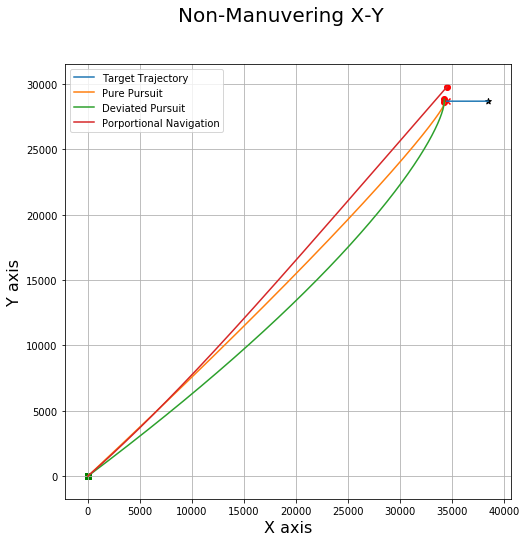

In [9]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XY", title = "Non-Manuvering X-Y")

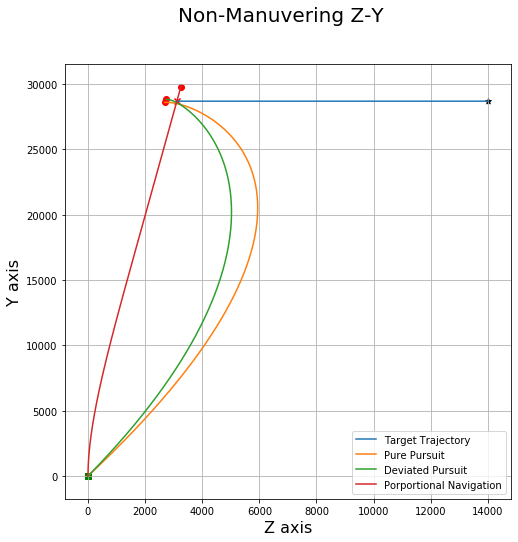

In [10]:
PlotComparisons(target0, missile0, missile1, missile2, view = "ZY", title = "Non-Manuvering Z-Y")

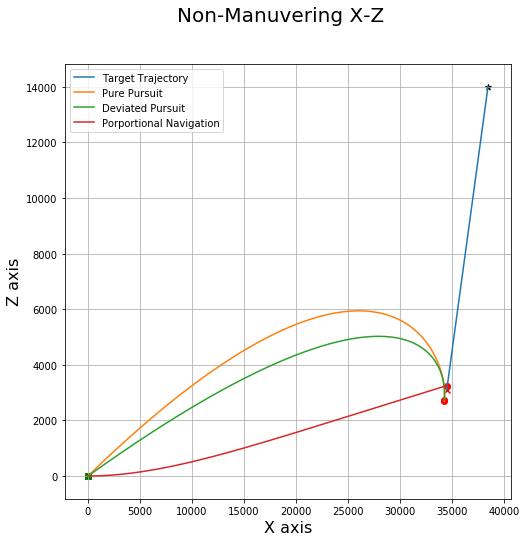

In [11]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XZ", title = "Non-Manuvering X-Z")

# Case 2: Outgoing Non-Manuvering Target

In [12]:
theta_t = 0
case2 = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target0, missile0, t0, Jtheta0, Jphi0 = case2.simulation(G = 0, S = 1, manuver_target = False, plot = False)
target1, missile1, t1, Jtheta1, Jphi1 = case2.simulation(G = 1, S = 1, manuver_target = False, plot = False)
target2, missile2, t2, Jtheta2, Jphi2 = case2.simulation(G = 2, S = 1, manuver_target = False, plot = False)

Missile hit the target using  Pure Pursuit  after  75.46000000000001  seconds
Missile hit the target using  Deviated Pursuit  after  76.19  seconds
Missile hit the target using  Porportional Navigation  after  75.22  seconds


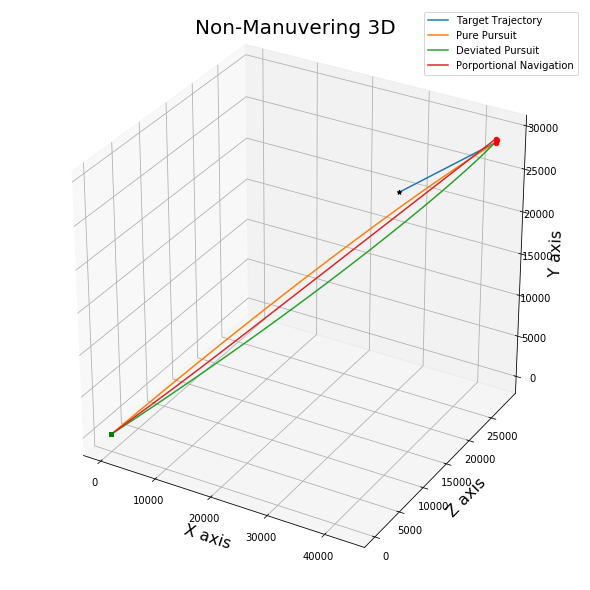

In [13]:
PlotComparisons(target0, missile0, missile1, missile2, view = "3D", title = "Non-Manuvering 3D")

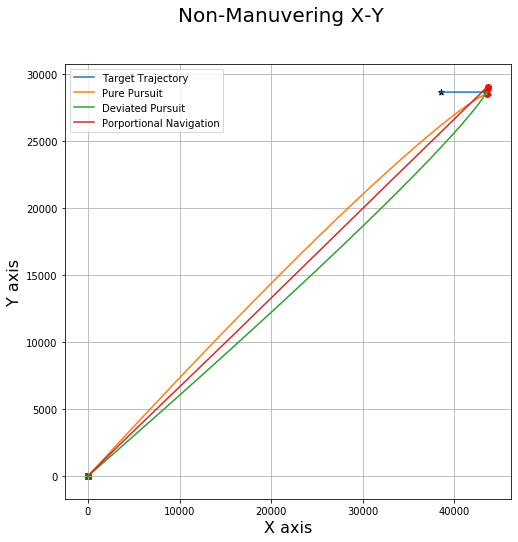

In [14]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XY", title = "Non-Manuvering X-Y")

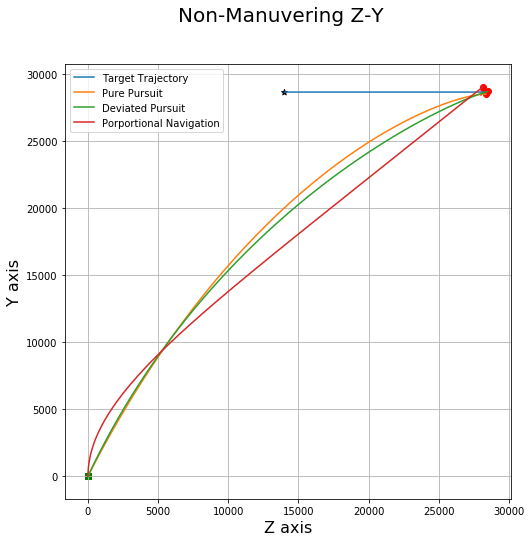

In [15]:
PlotComparisons(target0, missile0, missile1, missile2, view = "ZY", title = "Non-Manuvering Z-Y")

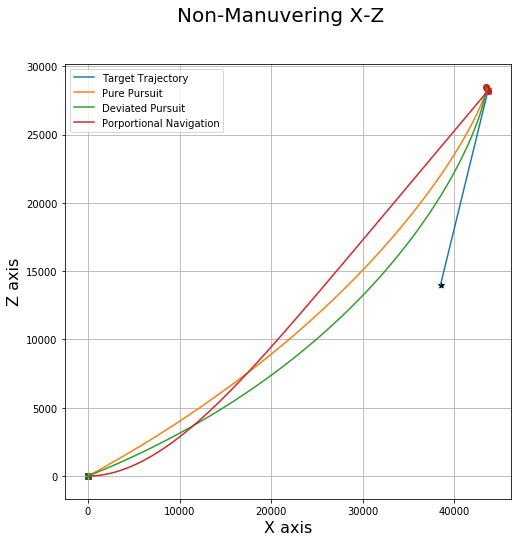

In [16]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XZ", title = "Non-Manuvering X-Z")

# Case 3: Incoming Manuvering Target

In [17]:
theta_t = 180
case3 = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target0, missile0, t0, Jtheta0, Jphi0 = case3.simulation(G = 0, S = 0, manuver_target = True, plot = False)
target1, missile1, t1, Jtheta1, Jphi1 = case3.simulation(G = 1, S = 0, manuver_target = True, plot = False)
target2, missile2, t2, Jtheta2, Jphi2 = case3.simulation(G = 2, S = 0, manuver_target = True, plot = False)

Missile hit the target using  Pure Pursuit  after  58.04  seconds
Missile hit the target using  Deviated Pursuit  after  57.730000000000004  seconds
Missile hit the target using  Porportional Navigation  after  56.94  seconds


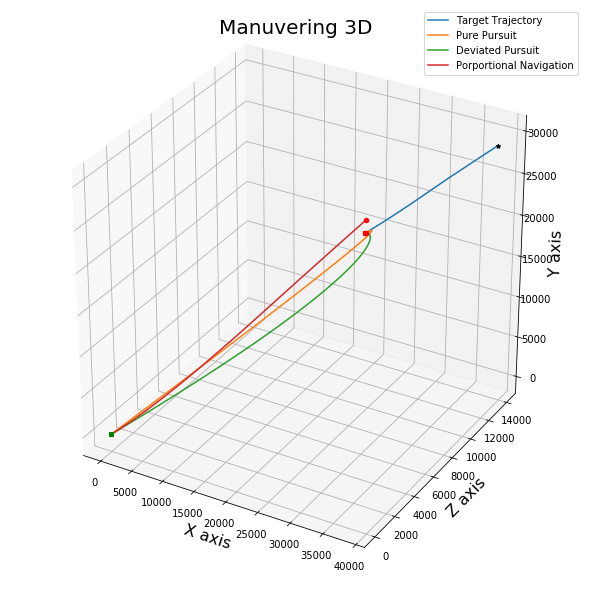

In [18]:
PlotComparisons(target0, missile0, missile1, missile2, view = "3D", title = "Manuvering 3D")

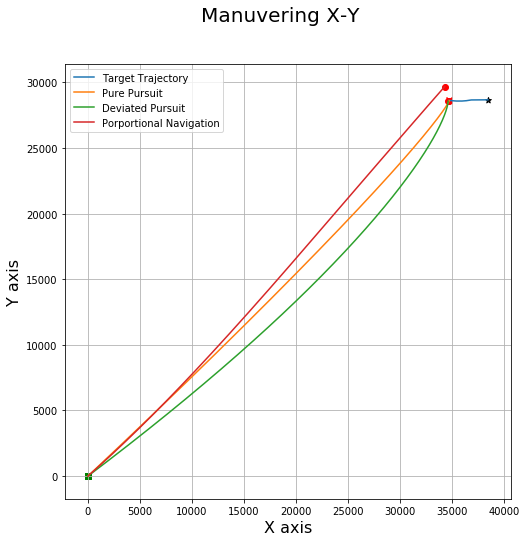

In [19]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XY", title = "Manuvering X-Y")

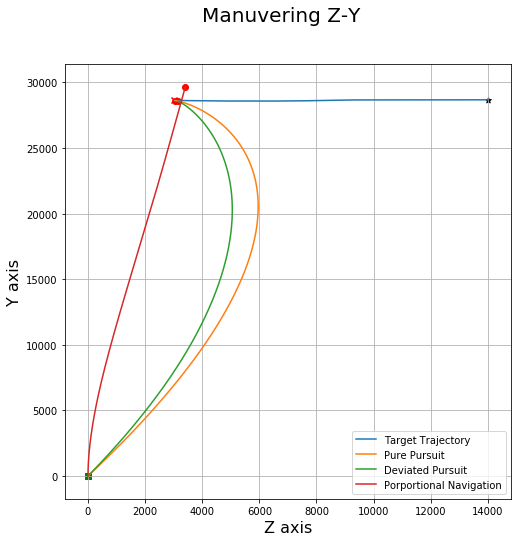

In [20]:
PlotComparisons(target0, missile0, missile1, missile2, view = "ZY", title = "Manuvering Z-Y")

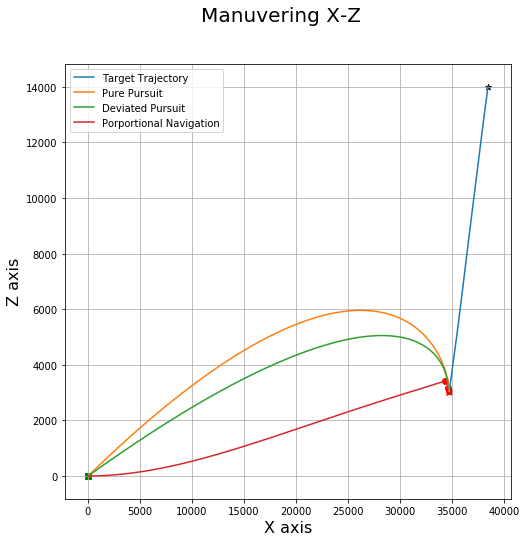

In [21]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XZ", title = "Manuvering X-Z")

# Case 4: Outgoing Manuvering Target

In [22]:
theta_t = 0
case4 = Simulation(D0, epsilon0, sigma0, VT, VM, dt, tf, theta_t, phi_t, theta_m, phi_m)
target0, missile0, t0, Jtheta0, Jphi0 = case4.simulation(G = 0, S = 0, manuver_target = True, plot = False)
target1, missile1, t1, Jtheta1, Jphi1 = case4.simulation(G = 1, S = 0, manuver_target = True, plot = False)
target2, missile2, t2, Jtheta2, Jphi2 = case4.simulation(G = 2, S = 0, manuver_target = True, plot = False)

Missile hit the target using  Pure Pursuit  after  74.78  seconds
Missile hit the target using  Deviated Pursuit  after  76.06  seconds
Missile hit the target using  Porportional Navigation  after  75.32000000000001  seconds


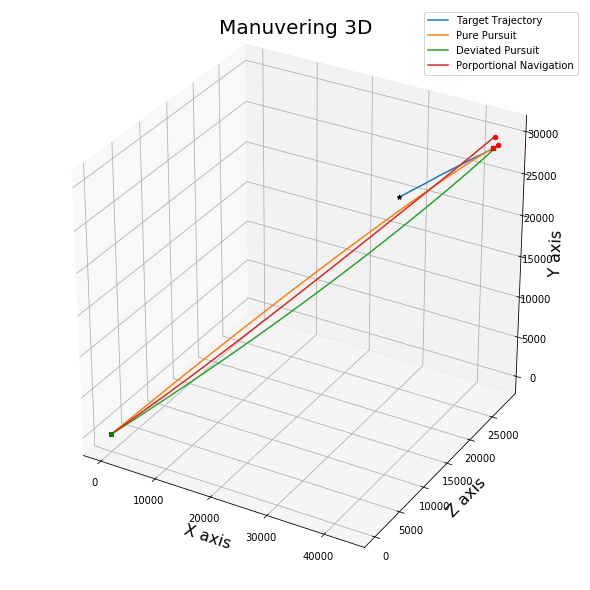

In [23]:
PlotComparisons(target0, missile0, missile1, missile2, view = "3D", title = "Manuvering 3D")

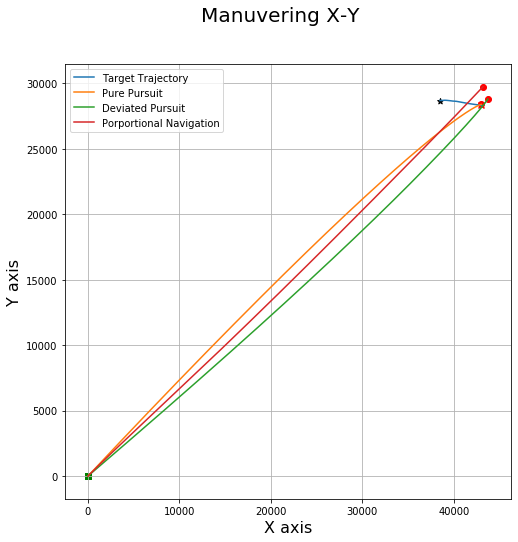

In [24]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XY", title = "Manuvering X-Y")

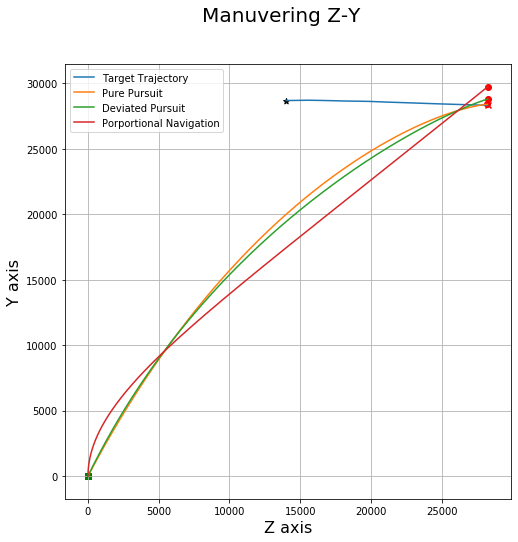

In [25]:
PlotComparisons(target0, missile0, missile1, missile2, view = "ZY", title = "Manuvering Z-Y")

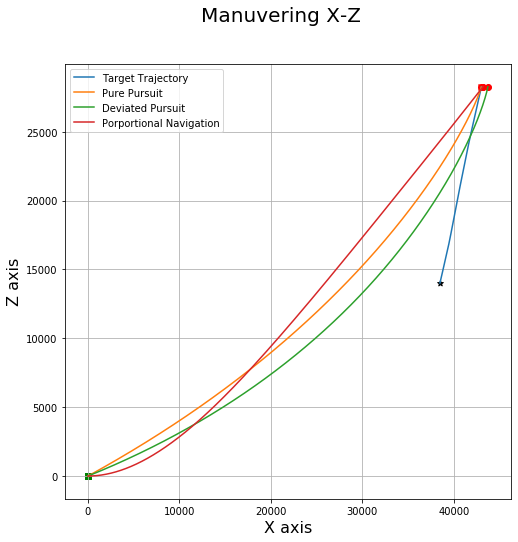

In [26]:
PlotComparisons(target0, missile0, missile1, missile2, view = "XZ", title = "Manuvering X-Z")

# Conclusion:
<ol>
<li>As noticed from the previous case studies, the missile that uses Porportional Navigation is able to intercept the target faster than its counterparts.
<li>Also, the missile that uses Porportional Navigation, the ideal bond works as D controller in PID, this is because the ideal bond equation makes the missile able to estimate the future trajectory of the target based on its current rate of change. This also reduce the need to do manuvers and makes the missile follow straight path more than its counterparts.
<li>Porportional Navigation guidance law makes use of the characteristics of homming radar on the missile, exploiting the doppler effect of the radar to measure the velocity and radial velocity, and makes an opportunity for improvement using filtering algorithms.
<li>Furthermore, it has been noticed that Pure Pursuit tends to be more accurate in the pursuit than Porportional navigation but it needs longer intercept distance than Porportional Navigation. So, if the intercept distance was small, the Pure Pursuit would be very likely to miss the target while the Porportional Navigation would succeed.
<ol>